In [1]:
import time

import numpy as np
import pandas as pd
from IPython.display import Image
import pydotplus
import graphviz

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = '/Users/guest/Dropbox/Education/Thinkful/Unit 2 - Supervised learning/L1 - Preparing to model/titanic_train.csv'
tt_df = pd.read_csv(path)

## Feature Engineering

In [3]:
# Create title feature
# Borrowed from: https://www.kaggle.com/matlihan/feature-engineering-for-titanic-dataset

NameSplit = tt_df.Name.str.split('[,.]')
titles = [str.strip(name[1]) for name in NameSplit.values]
titles[:10]

# new feature
tt_df['Title'] = titles

# reduce redundancy
tt_df.Title.values[tt_df.Title.isin(['Mme', 'Mlle'])] = 'Mlle'
tt_df.Title.values[tt_df.Title.isin(['Capt', 'Don', 'Major', 'Sir'])] = 'Sir'
tt_df.Title.values[tt_df.Title.isin(['Dona', 'Lady', 'the Countess', 'Jonkheer'])] = 'Lady'

In [4]:
# Drop name, which is no longer relevant & ticket,
# which I don't plan on using today.
tt_df = tt_df.drop(['Name', 'Ticket'], axis=1)

In [5]:
# Add overall family size
tt_df['FamilySize'] = tt_df['SibSp'] + tt_df['Parch']

In [6]:
# Strip cabin numbers from cabin, leaving only the lettered section.
# Strip cabin numbers from cabin, leaving only the lettered section.
tt_df['Cabin'] = tt_df['Cabin'].str.replace('[^a-zA-Z]', '')
tt_df['Cabin'] = tt_df['Cabin'].apply(lambda x: x if pd.isnull(x) else x[0])
tt_df['Cabin'] = tt_df['Cabin'].replace(np.nan, 'NA', regex=True)

In [7]:
# Drop NAs
tt_df.dropna(inplace=True)

# Create dummy variables
tt_df = pd.get_dummies(tt_df)

## Modeling

In [8]:
# Define y
y = tt_df['Survived']

# Create a holdout group
X_train, X_test, y_train, y_test = train_test_split(tt_df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(569, 33) (569,)
(143, 33) (143,)


In [9]:
# Create a function that will summarize 
def evaluate_model(model):
    cross_validation = cross_val_score(model, X_train, y_train, cv=10)
    performance = {
        'model':str(model).split('(')[0],
        'holdout performance':round(model.score(X_test, y_test),2),
        'cross validation':cross_validation,
        'cross validation mean':round(cross_validation.mean(),2),
        'cross validation standard deviation':round(cross_validation.std(),4),
        'execution time':execution_time
    }
    
    for key in performance:
        print('{}: {}'.format(key,performance[key]))
        
    return performance

#### Decision Tree

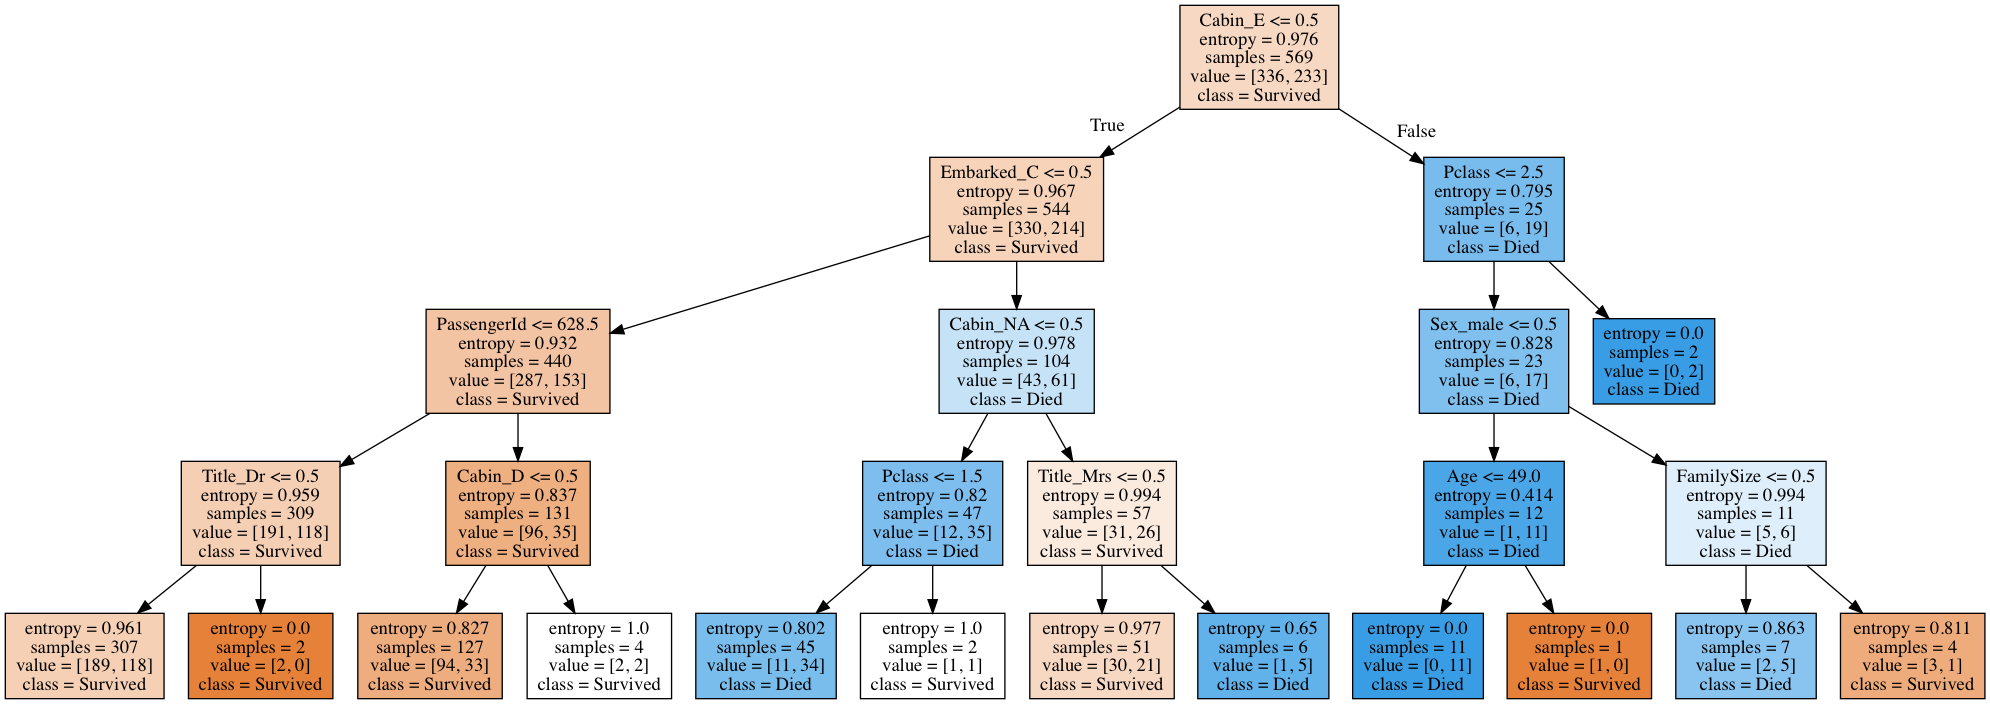

In [10]:
# Start a timer
start_time = time.clock()

# Initialize and train our tree.
dt_titanic = tree.DecisionTreeClassifier(criterion='entropy',
                                         max_features=1,
                                         max_depth=4,
                                        )

dt_titanic.fit(X_train, y_train)

# Render our tree.
dot_data = tree.export_graphviz(
    dt_titanic, out_file=None,
    feature_names=X_train.columns,
    class_names=['Survived', 'Died'],
    filled=True
)

execution_time = round(time.clock() - start_time,4)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [11]:
data_tree_performance = evaluate_model(dt_titanic)

model: DecisionTreeClassifier
holdout performance: 0.65
cross validation: [ 0.86206897  0.68965517  0.74137931  0.68421053  0.8245614   0.9122807
  0.66071429  0.85714286  0.73214286  0.64285714]
cross validation mean: 0.76
cross validation standard deviation: 0.0909
execution time: 0.0125


#### Random Forest

In [12]:
# Start a timer
start_time = time.clock()

rfc_titanic = RandomForestClassifier()
rfc_titanic.fit(X_train, y_train)

execution_time = round(time.clock() - start_time,4)

In [13]:
rfc_performance = evaluate_model(rfc_titanic)

model: RandomForestClassifier
holdout performance: 1.0
cross validation: [ 1.          0.98275862  0.98275862  0.98245614  0.98245614  0.98245614
  1.          1.          0.98214286  1.        ]
cross validation mean: 0.99
cross validation standard deviation: 0.0086
execution time: 0.027


#### Comparison

In [14]:
model_performance = pd.concat([pd.DataFrame(data_tree_performance), pd.DataFrame(rfc_performance)])

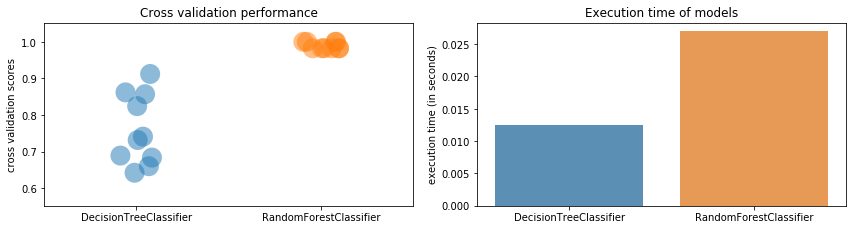

In [15]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(221)
sns.stripplot(x='model', 
              y='cross validation', 
              data=model_performance,
              size=20, 
              alpha=0.5,
              jitter=True)
ax1.set_title('Cross validation performance')
ax1.set_ylabel('cross validation scores')
ax1.set_xlabel('')


ax2 = plt.subplot(222)
sns.barplot(x='model', 
            y='execution time', 
            data=model_performance,
            alpha=0.8)
ax2.set_title('Execution time of models')
ax2.set_xlabel('')
ax2.set_ylabel('execution time (in seconds)')

plt.tight_layout()
plt.show()